In [ ]:
import requests
from bs4 import BeautifulSoup
import time

str_header="""Host: www.104.com.tw
Connection: keep-alive
Accept: application/json, text/plain, */*
User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/81.0.4044.138 Safari/537.36
Sec-Fetch-Site: same-origin
Sec-Fetch-Mode: cors
Sec-Fetch-Dest: empty
Referer: https://www.104.com.tw/job/6o5i0
Accept-Encoding: gzip, deflate, br
Accept-Language: zh-TW,zh;q=0.9,en-US;q=0.8,en;q=0.7
"""

{'Date': 'Sat, 09 May 2020 00:37:57 GMT', 'Content-Type': 'text/html; charset=UTF-8', 'Content-Length': '2228', 'Connection': 'keep-alive', 'Vary': 'Accept-Encoding', 'Content-Encoding': 'gzip', 'Front-End-Https': 'on', 'Set-Cookie': 'TS016ab800=01180e452d447870c5f452d85488b1a7ad8f0445b471a67640a3e4f8f1883525b34600a26adbd440752ab86b6cbb1b93aca7ae5fd6; Path=/'}

#headers = {i.split(": ")[0]:i.split(": ")[-1] for i in str_header.split("\n")}

#print(headers)



useragent = "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/81.0.4044.122 Safari/537.36"

#url="https://www.104.com.tw/job/2ybr3?jobsource=hotjob_chr"
url= 'https://www.104.com.tw/job/ajax/content/2ybr3'


headers={'Referer':'https://www.104.com.tw/job/2ybr3?jobsource=hotjob_chr',
        'user-agent' : useragent}
#headers={'user-agent' : useragent}

#print(cookie_dict)
#res=requests.get(url=url, headers=headers, cookies = cookie_dict)
res=requests.get(url=url, headers=headers)

#res=requests.Response(url) 

#ss=requests.session()
#ss.cookies['TS016ab800'] = '01180e452d84d2fb1578edb1c8e0a3d9327411e119ada25b25c397c16877d502818ba08e7d9849cb6b463a62b159935eab716798fc'
#res=requests.get(url, headers, timeout=120.0)
#res=ss.get(url)
time.sleep(1)
#print(res.headers)
#print(res.status_code)
#print(res.encoding)
#print(res.json())
print(res.text)

#print(res.cookies)
#print(res.content)


#soup= BeautifulSoup(res.text, 'html.parser')
#soup.text
#joblist=soup.select('article')    


# HAR 分析 

In [ ]:
from browsermobproxy import Server
from selenium import webdriver
from selenium.webdriver import Chrome

base_url= 'https://www.104.com.tw/job/2ybr3?jobsource=hotjob_chr'
server = Server("./browsermob-proxy-2.1.4/bin/browsermob-proxy.bat")
#server = Server('./browsermob-proxy-2.1.4/bin/browsermob-proxy')
server.start()
proxy = server.create_proxy()

from selenium import webdriver
from selenium.webdriver.chrome.options import Options
 
chrome_options = Options()
chrome_options.add_argument('--ignore-certificate-errors')
chrome_options.add_argument('--proxy-server={0}'.format(proxy.proxy))
chrome_options.add_argument('--disable-gpu')
chrome_driver='./chromedriver'
driver = webdriver.Chrome(executable_path=chrome_driver, chrome_options = chrome_options)

proxy.new_har(base_url)
driver.get(base_url)


result = proxy.har
print (result)
    
for entry in result['log']['entries']:
    print(entry['request']['url'])


server.stop()
driver.quit()

# Get json from 104 website

In [ ]:
import requests
from bs4 import BeautifulSoup
import re
import os
import time
import random
import json


if os.path.exists('job101_info_json'):
    pass
else:
    os.mkdir('job101_info_json')

useragent = "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/81.0.4044.122 Safari/537.36"

headers={'user-agent' : useragent}


for page in range(1,20):
    
    keywords = {'ro':'1', # 限定全職的工作，如果不限定則輸入0
             'keyword':'大數據%20bigdata', # 想要查詢的關鍵字
             'area':'6001001000', # 限定在台北的工作
             'isnew':'30', # 只要最近一個月有更新的過的職缺
             'order':'15', #每個page顯示的數量
             'page': str(page), #第幾個page
             'mode':'s'} #'l' 清單的瀏覽模式, 's' 複雜的瀏覽模式

    url='https://www.104.com.tw/jobs/search/?\
    ro={ro}&keyword={keyword}&area={area}&isnew={isnew}&order={order}&page={page}&mode={mode}'.format(**keywords)

    #print(url)


    res=requests.get(url, headers)
    soup= BeautifulSoup(res.text, 'html.parser')
    joblist=soup.select('article')   
    
    
    for eachjob in joblist:
        try:
            #print(eachjob)
            url= eachjob.select('a.js-job-link')[0]['href']
            #print(url)
            _headers={'Referer':'https:' + url,
                     'user-agent' : useragent}
            #print(_headers)
        except IndexError:
            continue
        json_url_str= re.findall("job.*\?", url)[0].replace('job/',"").replace('?',"")
        json_url='https://www.104.com.tw/job/ajax/content/'+json_url_str
        _res=requests.get(url=json_url, headers=_headers)
        #print(page, json_url)
        #print(_res.text)
    
        time.sleep(random.uniform(2,5))
        
        #soup= BeautifulSoup(_res.text, 'html.parser')
        json_data=json.loads(_res.text)
        json_job=json_data['data']
        filename='./job101_info_json/{}.json'.format(json_url_str)
        with open(filename, 'w') as f:
            json.dump(json_job, f)
        print('processing page: {}: write to {}'.format(page, filename))

# import Json to Pandas

In [6]:
import pandas as pd
import json
from pandas.io.json import json_normalize
import re
import os


source_file_path='./job101_info_json'
file_list=os.listdir(source_file_path)

jobinfo_List=[]

for each_file in file_list:
    cpath=source_file_path+'/'+each_file

    with open(cpath, 'r') as f:
        each_jobinfo_Dict= json.loads(f.read())
        #print(each_jobinfo_Dict)
        
    jobinfo_List.append(each_jobinfo_Dict)
#df= json_normalize(jobinfo_List, max_level=2) 
df= json_normalize(jobinfo_List, max_level=2)
df.head()

D:\anaconda3\envs\PyETL\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead


,switch,custLogo,postalCode,closeDate,industry,custNo,reportUrl,corpImageRight.corpImageRight.imageUrl,corpImageRight.corpImageRight.link,header.corpImageTop.imageUrl,...,jobDetail.longitude,jobDetail.latitude,jobDetail.manageResp,jobDetail.businessTrip,jobDetail.workPeriod,jobDetail.vacationPolicy,jobDetail.startWorkingDay,jobDetail.hireType,jobDetail.delegatedRecruit,jobDetail.needEmp
0,on,https://static.104.com.tw/b_profile/4/80260294...,114,2018-11-15,電腦系統整合服務業,80260294000,https://www.104.com.tw/question_admin/reaction...,,,,...,121.5909027,25.0689422,不需負擔管理責任,需出差，一年累積時間未定,日班,依公司規定,不限,0,,1~2人
1,on,https://static.104.com.tw/b_profile/7/70769567...,114,,電信相關業,70769567000,https://www.104.com.tw/question_admin/reaction...,,,,...,121.5667312,25.0782073,不需負擔管理責任,無需出差外派,日班，09:00-18:00,週休二日,兩週內,0,,1人
2,on,https://static.104.com.tw/b_profile/2/50523220...,100,,銀行業,5052322000,https://www.104.com.tw/question_admin/reaction...,,,,...,121.5131252,25.0457944,不需負擔管理責任,無需出差外派,日班,週休二日,一個月內,0,,1~2人
3,on,https://static.104.com.tw/b_profile/6/34340160...,105,,人身保險業,3434016000,https://www.104.com.tw/question_admin/reaction...,,,,...,121.548392,25.0541725,不需負擔管理責任,無需出差外派,日班，08:30~17:30,週休二日,不限,0,,1人
4,on,https://static.104.com.tw/b_profile/5/80333825...,106,,電腦軟體服務業,80333825000,https://www.104.com.tw/question_admin/reaction...,,,,...,121.5427093,25.0261583,不需負擔管理責任,無需出差外派,日班,週休二日,不限,0,,3人


# Confirm Pandas Columns

In [8]:
df2=df.copy()
df2.columns

Index(['switch', 'custLogo', 'postalCode', 'closeDate', 'industry', 'custNo',
       'reportUrl', 'corpImageRight.corpImageRight.imageUrl',
       'corpImageRight.corpImageRight.link', 'header.corpImageTop.imageUrl',
       'header.corpImageTop.link', 'header.jobName', 'header.appearDate',
       'header.custName', 'header.custUrl', 'header.applyDate',
       'header.analysisType', 'header.analysisUrl', 'header.isSaved',
       'header.isApplied', 'contact.hrName', 'contact.email', 'contact.visit',
       'contact.phone', 'contact.other', 'contact.reply',
       'environmentPic.environmentPic',
       'environmentPic.corpImageBottom.imageUrl',
       'environmentPic.corpImageBottom.link', 'condition.acceptRole.role',
       'condition.acceptRole.disRole', 'condition.workExp', 'condition.edu',
       'condition.major', 'condition.language', 'condition.localLanguage',
       'condition.specialty', 'condition.skill', 'condition.certificate',
       'condition.driverLicense', 'condition.ot

# Confirm condition.other infomation  
# Apply FIlter for Skill Analysis

In [9]:
import pandas as pd
import json
import jieba


source_file_path='./job101_info_json'
file_list=os.listdir(source_file_path)

jobinfo_List=[]

for each_file in file_list:
    cpath=source_file_path+'/'+each_file

    with open(cpath, 'r') as f:
        each_jobinfo_Dict= json.loads(f.read())
        #print(each_jobinfo_Dict)
        
    jobinfo_List.append(each_jobinfo_Dict)
    
df= json_normalize(jobinfo_List, max_level=2)



#for english space of keywords
#jieba.re_han_default = re.compile("([\u4E00-\u9FD5a-zA-Z0-9+#&\._% ]+)", re.U)
jieba.re_han_default = re.compile('(.+)', re.U) 

#load userdict
jieba.load_userdict('./jobskill.txt')

#jieba.add_word('Data Mining')
#jieba.add_word('Data Modeling')
#jieba.add_word('neural network')
#jieba.add_word('machine learning')

# import skill-definition
jobskill_def=[]

with open('jobskill.txt', 'r', encoding='utf-8') as file:
    for _skill in file.readlines():
        _skill = _skill.strip()
        jobskill_def.append(_skill.upper())
#print(jobskill_def)
        
def skill_filter(skillDesc):
    #print(skillDesc)
    #skillDesc=skillDesc.split('\n')
    #all_line=""
    #for line in skillDesc:
    #    all_line+=line
        
    #print(all_line)
    #jieba_list=jieba.cut(all_line, cut_all=True)
    jieba_list=jieba.cut(skillDesc, cut_all=False)
    #jieba_list=jieba.cut(all_line, cut_all=False)
    #print("|".join(jieba_list))
    
    skill_Dict={}
    for _skill in jobskill_def:
        skill_Dict[_skill] = 0
    
    for _word in jieba_list:
        _word = re.sub("[\!\%\[\]\,\。,\.]", "", _word)
        #_word = re.sub(u'[^0-9a-zA-Z\u4e00-\u9fa5.，,。？“”]+',"", _word)
        #print(_word)

        if _word.upper() in jobskill_def:
            skill_Dict[_word.upper()]=1
    #print(skill_Dict)
    
    _job_skill_list=[]
    
    for k, v in skill_Dict.items():
         _job_skill_list.append(v)
        
    return _job_skill_list



data1="""(1) 資料庫語言 (SQL)\n(2) ETL 工具 (Trinity)\n(3) 爬網程式\
(Python)\n(4) Data Mining (R/SAS/SPSS)\n(5) Data Modeling\n(6) 熟悉大數據架構(HDFS)\n(7)\
#統計分析專業知識\n(8) 掌握各產業知識"""

data2 = """1.國內外大學以上(數理統計、資工資管等相關等系所畢)。\n2.
熟悉資料結構與關聯式資料庫存取語言SQL並具備ETL相關技術。\n3.
熟悉Hadoop架構與Spark。\n4.具備程式撰寫能力(R或Python)。\n5.
具大數據機器學習相關開發框架(如TensorFlow)經驗佳。"""


#print(skill_filter(data1))
#print(skill_filter(data2))




df2['condition.other']=df2['condition.other'].apply(skill_filter)
df2[['condition.other']].head()

print("analysis is done!!")

#Split condition.other by jobskill_def
df2[jobskill_def] = df2['condition.other'].apply(pd.Series)
df2[jobskill_def].head()

D:\anaconda3\envs\PyETL\lib\site-packages\ipykernel_launcher.py:20: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead


analysis is done!!


,AWS,AGILE,AI,C,C#,C++,DATA MINING,DATA MODELING,ELASTICSEARCH,ETL,...,SCALA,SQOOP,SOLR,SPARK,SQL,SAS,SPSS,TENSORFLOW,TRINITY,ZOOKEEPER
0,0,0,0,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,1,1,0,1,...,0,0,0,0,1,1,1,0,1,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Accept role Analysis

In [10]:
Index_condition=['condition.acceptRole.role', 
        'condition.workExp', 'condition.edu',
        'condition.major', 'condition.language','condition.other']
df2[Index_condition].head()

,condition.acceptRole.role,condition.workExp,condition.edu,condition.major,condition.language,condition.other
0,"[{'code': 1, 'description': '上班族'}, {'code': 2...",不拘,大學、碩士,[],"[{'language': '英文', 'ability': '聽 /中等、說 /中等、讀 ...","[0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,"[{'code': 1, 'description': '上班族'}, {'code': 6...",2年以上,大學、碩士,[],[],"[0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, ..."
2,"[{'code': 1, 'description': '上班族'}]",1年以上,大學以上,[],[],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,"[{'code': 1, 'description': '上班族'}]",3年以上,大學、碩士,[],[],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, ..."
4,"[{'code': 1, 'description': '上班族'}, {'code': 2...",不拘,專科、大學、碩士,"[電機電子工程相關, 資訊工程相關, 其他數學及電算機科學相關]","[{'language': '英文', 'ability': '聽 /略懂、說 /略懂、讀 ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [11]:
def role_filter(rolelist):
    if isinstance(rolelist, list):
        rolelist_filter=[]
        for _role_dict in rolelist:
            rolelist_filter.append(_role_dict['description'])
        return rolelist_filter
    else:
        return rolelist
    
#print(role_filter(rolelist))
df2['condition.acceptRole.role']= df2['condition.acceptRole.role'].apply(role_filter)
df2[['condition.acceptRole.role']].head()

,condition.acceptRole.role
0,"[上班族, 應屆畢業生, 原住民]"
1,"[上班族, 原住民]"
2,[上班族]
3,[上班族]
4,"[上班族, 應屆畢業生]"


# Double Check Info for CSV File

In [12]:
Index_header=[]
Index_header=['header.jobName', 'header.appearDate','header.custName', 'header.custUrl']
df2[Index_header].head(10)

,header.jobName,header.appearDate,header.custName,header.custUrl
0,大數據 工程師,2020/04/27,動力安全資訊股份有限公司,https://www.104.com.tw/company/10vcwn74
1,03_大數據科學家,2020/04/23,台灣之星電信股份有限公司,https://www.104.com.tw/company/wiedfdk
2,大數據分析人員,2020/04/21,第一銀行_第一商業銀行股份有限公司,https://www.104.com.tw/company/2bk0sls
3,F-大數據資料工程師,2020/04/27,中國人壽保險股份有限公司(總公司),https://www.104.com.tw/company/1ksivpc
4,大數據技術專員,2020/04/29,中華系統整合股份有限公司,https://www.104.com.tw/company/10wkoo2w
5,Big Data Solution PO 大數據應用產品經理,2020/04/28,91APP_九易宇軒股份有限公司,https://www.104.com.tw/company/1a2x6bio5g
6,大數據工程師(POD00),2020/05/03,PChome Online_網路家庭國際資訊(股)公司,https://www.104.com.tw/company/7mmueb6
7,大數據系統工程師,2020/04/29,薩摩亞商長穩智能管理有限公司,https://www.104.com.tw/company/1a2x6bjmmv
8,【資訊】大數據分析人員,2020/04/27,群益金鼎證券股份有限公司,https://www.104.com.tw/company/ajnfhyw
9,大數據工程師,2020/04/27,艾斯移動股份有限公司,https://www.104.com.tw/company/cv8shww


In [13]:
Index_JD=['jobDetail.salary', 'jobDetail.salaryMin', 'jobDetail.salaryMax',
        'jobDetail.addressRegion','jobDetail.needEmp']
df2[Index_JD].head()

,jobDetail.salary,jobDetail.salaryMin,jobDetail.salaryMax,jobDetail.addressRegion,jobDetail.needEmp
0,"月薪30,000~40,000元",30000,40000,台北市內湖區,1~2人
1,待遇面議,0,0,台北市內湖區,1人
2,"月薪30,000~55,000元",30000,55000,台北市中正區,1~2人
3,待遇面議,0,0,台北市松山區,1人
4,"月薪31,000~60,000元",31000,60000,台北市大安區,3人


In [14]:
Index_JD=['jobDetail.salary', 'jobDetail.salaryMin', 'jobDetail.salaryMax',
        'jobDetail.addressRegion','jobDetail.needEmp']
Index_header.extend(Index_JD)
df2[Index_header].head()

,header.jobName,header.appearDate,header.custName,header.custUrl,jobDetail.salary,jobDetail.salaryMin,jobDetail.salaryMax,jobDetail.addressRegion,jobDetail.needEmp
0,大數據 工程師,2020/04/27,動力安全資訊股份有限公司,https://www.104.com.tw/company/10vcwn74,"月薪30,000~40,000元",30000,40000,台北市內湖區,1~2人
1,03_大數據科學家,2020/04/23,台灣之星電信股份有限公司,https://www.104.com.tw/company/wiedfdk,待遇面議,0,0,台北市內湖區,1人
2,大數據分析人員,2020/04/21,第一銀行_第一商業銀行股份有限公司,https://www.104.com.tw/company/2bk0sls,"月薪30,000~55,000元",30000,55000,台北市中正區,1~2人
3,F-大數據資料工程師,2020/04/27,中國人壽保險股份有限公司(總公司),https://www.104.com.tw/company/1ksivpc,待遇面議,0,0,台北市松山區,1人
4,大數據技術專員,2020/04/29,中華系統整合股份有限公司,https://www.104.com.tw/company/10wkoo2w,"月薪31,000~60,000元",31000,60000,台北市大安區,3人


In [15]:
Index_contact=['contact.hrName', 'contact.email','contact.phone']
df2[Index_contact].head()

,contact.hrName,contact.email,contact.phone
0,HR,,
1,人力資源處,,
2,楊先生,,
3,吳小姐,,
4,顏小姐,"benyu@ch-si.com.tw,shiviegao@ch-si.com.tw,ypli...",02-21926999-115


In [16]:
Index_contact=['contact.hrName', 'contact.email','contact.phone']
Index_header.extend(Index_contact)
df2[Index_header].head()

,header.jobName,header.appearDate,header.custName,header.custUrl,jobDetail.salary,jobDetail.salaryMin,jobDetail.salaryMax,jobDetail.addressRegion,jobDetail.needEmp,contact.hrName,contact.email,contact.phone
0,大數據 工程師,2020/04/27,動力安全資訊股份有限公司,https://www.104.com.tw/company/10vcwn74,"月薪30,000~40,000元",30000,40000,台北市內湖區,1~2人,HR,,
1,03_大數據科學家,2020/04/23,台灣之星電信股份有限公司,https://www.104.com.tw/company/wiedfdk,待遇面議,0,0,台北市內湖區,1人,人力資源處,,
2,大數據分析人員,2020/04/21,第一銀行_第一商業銀行股份有限公司,https://www.104.com.tw/company/2bk0sls,"月薪30,000~55,000元",30000,55000,台北市中正區,1~2人,楊先生,,
3,F-大數據資料工程師,2020/04/27,中國人壽保險股份有限公司(總公司),https://www.104.com.tw/company/1ksivpc,待遇面議,0,0,台北市松山區,1人,吳小姐,,
4,大數據技術專員,2020/04/29,中華系統整合股份有限公司,https://www.104.com.tw/company/10wkoo2w,"月薪31,000~60,000元",31000,60000,台北市大安區,3人,顏小姐,"benyu@ch-si.com.tw,shiviegao@ch-si.com.tw,ypli...",02-21926999-115


In [17]:
#add job skill items
Index_header.extend(jobskill_def)
df2[Index_header].head()

,header.jobName,header.appearDate,header.custName,header.custUrl,jobDetail.salary,jobDetail.salaryMin,jobDetail.salaryMax,jobDetail.addressRegion,jobDetail.needEmp,contact.hrName,...,SCALA,SQOOP,SOLR,SPARK,SQL,SAS,SPSS,TENSORFLOW,TRINITY,ZOOKEEPER
0,大數據 工程師,2020/04/27,動力安全資訊股份有限公司,https://www.104.com.tw/company/10vcwn74,"月薪30,000~40,000元",30000,40000,台北市內湖區,1~2人,HR,...,0,0,0,0,0,0,0,0,0,0
1,03_大數據科學家,2020/04/23,台灣之星電信股份有限公司,https://www.104.com.tw/company/wiedfdk,待遇面議,0,0,台北市內湖區,1人,人力資源處,...,0,0,0,0,1,1,1,0,1,0
2,大數據分析人員,2020/04/21,第一銀行_第一商業銀行股份有限公司,https://www.104.com.tw/company/2bk0sls,"月薪30,000~55,000元",30000,55000,台北市中正區,1~2人,楊先生,...,0,0,0,0,0,1,0,0,0,0
3,F-大數據資料工程師,2020/04/27,中國人壽保險股份有限公司(總公司),https://www.104.com.tw/company/1ksivpc,待遇面議,0,0,台北市松山區,1人,吳小姐,...,0,0,0,0,1,0,0,0,0,0
4,大數據技術專員,2020/04/29,中華系統整合股份有限公司,https://www.104.com.tw/company/10wkoo2w,"月薪31,000~60,000元",31000,60000,台北市大安區,3人,顏小姐,...,0,0,0,0,0,0,0,0,0,0


In [18]:
#輸出csv
df2[Index_header].to_csv('./jbinfo_tmp.csv', index=0, encoding='utf-8-sig')
print("CSV output success!!")

CSV output success!!


# Final: Unite Code from josn reading to pandas/csv

In [1]:
import pandas as pd
import json
from pandas.io.json import json_normalize
import re
import os
import jieba

def json2pd(path):
    file_list=os.listdir(path)
    jobinfo_list=[]

    for each_file in file_list:
        cpath=source_file_path+'/'+each_file

        with open(cpath, 'r') as f:
            _jobinfo= json.loads(f.read())
        jobinfo_list.append(_jobinfo)  
    return json_normalize(jobinfo_list, max_level=2) 

def role_filter(rolelist):
    if isinstance(rolelist, list):
        rolelist_filter=[]
        for _role_dict in rolelist:
            rolelist_filter.append(_role_dict['description'])
        return rolelist_filter
    else:
        return rolelist
    
def skill_filter(skillDesc):
    jieba_list=jieba.cut(skillDesc, cut_all=False)
    skill_Dict={}
    for _skill in jobskill_def:
        skill_Dict[_skill] = 0
    
    for _word in jieba_list:
        _word = re.sub("[\!\%\[\]\,\。,\.]", "", _word)
        #_word = re.sub(u'[^0-9a-zA-Z\u4e00-\u9fa5.，,。？“”]+',"", _word)
        #print(_word)
        if _word.upper() in jobskill_def:
            skill_Dict[_word.upper()]=1
    
    _job_skill_list=[]
    
    for k, v in skill_Dict.items():
         _job_skill_list.append(v)
        
    return _job_skill_list


source_file_path='./job101_info_json'
df=json2pd(source_file_path)
jobskill_def=[]

with open('./jobskill.txt', 'r', encoding='utf-8') as file:
    for _skill in file.readlines():
        _skill = _skill.strip()
        jobskill_def.append(_skill.upper())

df['condition.other']=df['condition.other'].apply(skill_filter)
df[jobskill_def] = df['condition.other'].apply(pd.Series)
df['condition.acceptRole.role']= df['condition.acceptRole.role'].apply(role_filter)


#df colunm selection

Index_header=['header.jobName', 'header.appearDate','header.custName', 'header.custUrl',
              'condition.acceptRole.role', 'condition.workExp', 'condition.edu',
              'condition.major', 'condition.language','condition.other',
              'jobDetail.salary', 'jobDetail.salaryMin', 'jobDetail.salaryMax',
              'jobDetail.addressRegion','jobDetail.needEmp',
              'contact.hrName', 'contact.email','contact.phone']

Index_header.extend(jobskill_def)

df[Index_header].to_csv('./jbinfo_tmp.csv', index=0, encoding='utf-8-sig')
print("CSV output success!!")

df[Index_header].head()

D:\anaconda3\envs\PyETL\lib\site-packages\ipykernel_launcher.py:18: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\User\AppData\Local\Temp\jieba.cache
Loading model cost 0.829 seconds.
Prefix dict has been built succesfully.


CSV output success!!


,header.jobName,header.appearDate,header.custName,header.custUrl,condition.acceptRole.role,condition.workExp,condition.edu,condition.major,condition.language,condition.other,...,SCALA,SQOOP,SOLR,SPARK,SQL,SAS,SPSS,TENSORFLOW,TRINITY,ZOOKEEPER
0,大數據 工程師,2020/04/27,動力安全資訊股份有限公司,https://www.104.com.tw/company/10vcwn74,"[上班族, 應屆畢業生, 原住民]",不拘,大學、碩士,[],"[{'language': '英文', 'ability': '聽 /中等、說 /中等、讀 ...","[0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",...,0,0,0,0,0,0,0,0,0,0
1,03_大數據科學家,2020/04/23,台灣之星電信股份有限公司,https://www.104.com.tw/company/wiedfdk,"[上班族, 原住民]",2年以上,大學、碩士,[],[],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",...,0,0,0,0,1,1,1,0,1,0
2,大數據分析人員,2020/04/21,第一銀行_第一商業銀行股份有限公司,https://www.104.com.tw/company/2bk0sls,[上班族],1年以上,大學以上,[],[],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",...,0,0,0,0,0,1,0,0,0,0
3,F-大數據資料工程師,2020/04/27,中國人壽保險股份有限公司(總公司),https://www.104.com.tw/company/1ksivpc,[上班族],3年以上,大學、碩士,[],[],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, ...",...,0,0,0,0,1,0,0,0,0,0
4,大數據技術專員,2020/04/29,中華系統整合股份有限公司,https://www.104.com.tw/company/10wkoo2w,"[上班族, 應屆畢業生]",不拘,專科、大學、碩士,"[電機電子工程相關, 資訊工程相關, 其他數學及電算機科學相關]","[{'language': '英文', 'ability': '聽 /略懂、說 /略懂、讀 ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",...,0,0,0,0,0,0,0,0,0,0


# 薪資分析

In [2]:
(df[['jobDetail.salaryMin','jobDetail.salaryMax']])[(df['jobDetail.salaryMin'] > 0)].describe()

,jobDetail.salaryMin,jobDetail.salaryMax
count,4.660000e+02,4.660000e+02
mean,7.194190e+04,6.304414e+05
std,2.037350e+05,2.215783e+06
min,1.580000e+02,2.600000e+04
25%,3.000000e+04,5.500000e+04
50%,3.600000e+04,6.000000e+04
75%,5.000000e+04,8.500000e+04
max,2.000000e+06,9.999999e+06


# Job Skill Analysis

In [2]:
df_statics=df[jobskill_def].sum().sort_values(ascending=False)
df_statics

PYTHON              411
SQL                 359
HADOOP              305
JAVA                257
SPARK               222
HIVE                213
HBASE               204
R                   155
MYSQL               153
ETL                 135
SCALA               126
C#                  101
MONGODB             101
SAS                  92
KAFKA                89
FLUME                80
C                    70
C++                  64
AWS                  58
SCRUM                51
TENSORFLOW           51
SPSS                 47
AGILE                46
ELASTICSEARCH        44
HDFS                 42
OOZIE                42
LUIGI                41
SQOOP                41
FLUENTD              41
ZOOKEEPER            40
GOLANG               40
TRINITY              40
PIG                  40
SOLR                 40
LUCENE               40
JAVASCRIPT           33
AI                   20
DATA MODELING         0
DATA MINING           0
MACHINE LEARNING      0
NEURAL NETWORK        0
dtype: int64

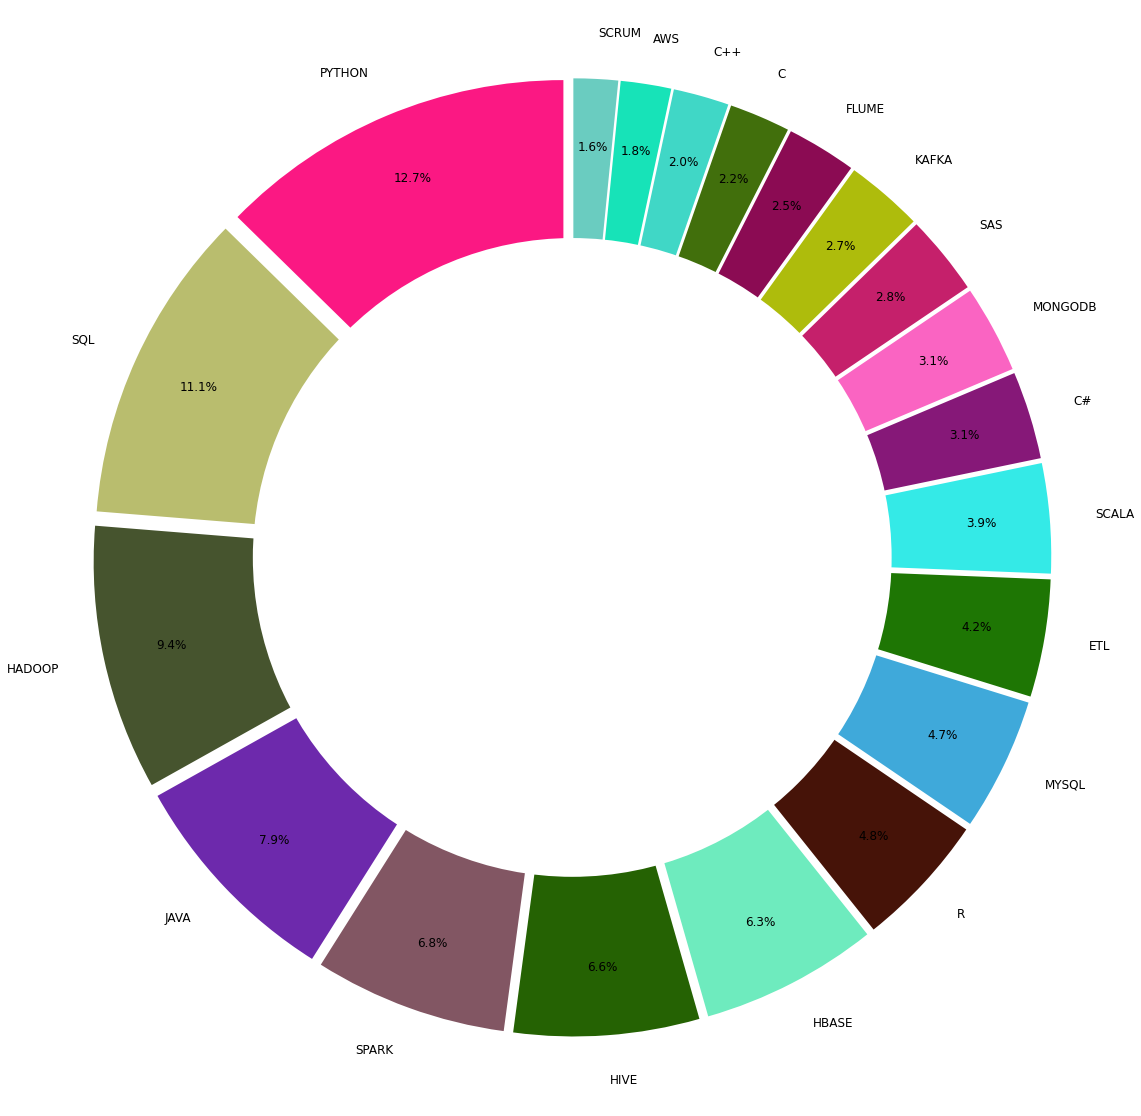

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import random


# Pie chart
sizes=[]
for x in df_statics[:20].values:
    if x>0:
        sizes.append(x)

labels=df_statics.index[:len(sizes)]

number_of_colors = len(sizes)

colors = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
             for i in range(number_of_colors)]
#print(colors)

#print(len(colors))
#colors
#colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']

#explsion

s=[0.05]*len(sizes)
explode = tuple(s)

fig = plt.figure(figsize=(16,16))

plt.pie(sizes, colors = colors, labels=labels, autopct='%1.1f%%', startangle=90, pctdistance=0.85, textprops={'fontsize': 12}, explode = explode)

#draw circle
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Equal aspect ratio ensures that pie is drawn as a circle
plt.axis('equal')  
plt.tight_layout()
plt.show()

In [5]:
df_statics.head()

PYTHON    411
SQL       359
HADOOP    305
JAVA      257
SPARK     222
dtype: int64

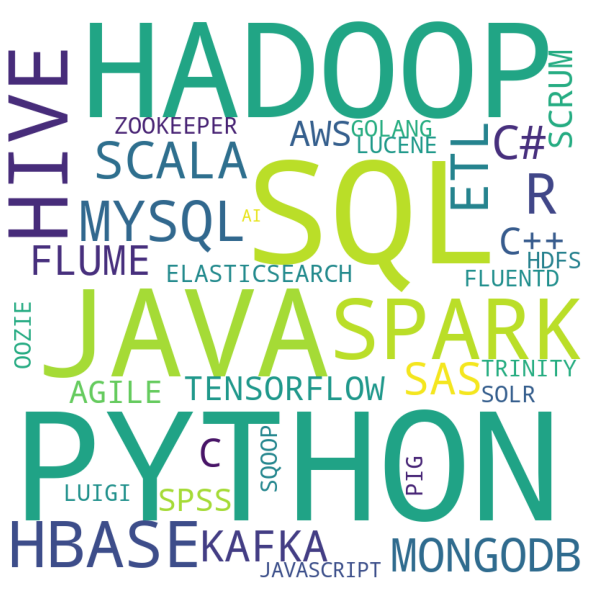

In [4]:
%matplotlib inline
from wordcloud import WordCloud
import matplotlib.pyplot as plt 

word_dict= df_statics.to_dict()

#print(word_dict)

#for k,v in word_list:
#    d[k] = int(v)

#wordcloud = WordCloud(font_path='simhei.ttf', width = 800, height = 800, 
#                background_color ='white', min_font_size = 10).generate(text) 
#wordcloud = WordCloud(width = 800, height = 800, background_color ='white', min_font_size = 10).generate(text) 
#

wordcloud = WordCloud(width = 800, height = 800, background_color ='white',
                      min_font_size = 10).generate_from_frequencies(word_dict) 
 
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()
